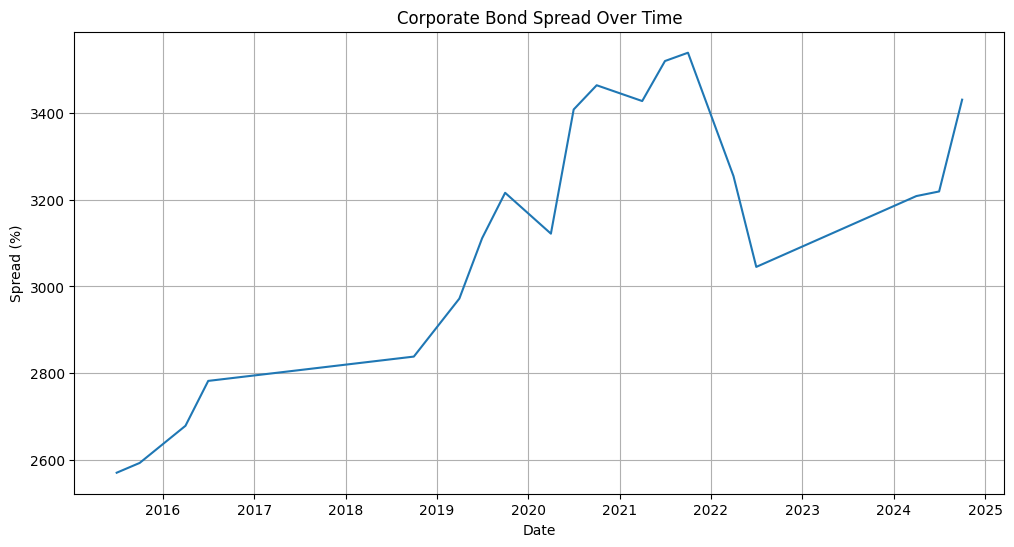

Crisis Regime (Higher Spread): 0
Calm Regime (Lower Spread): 1


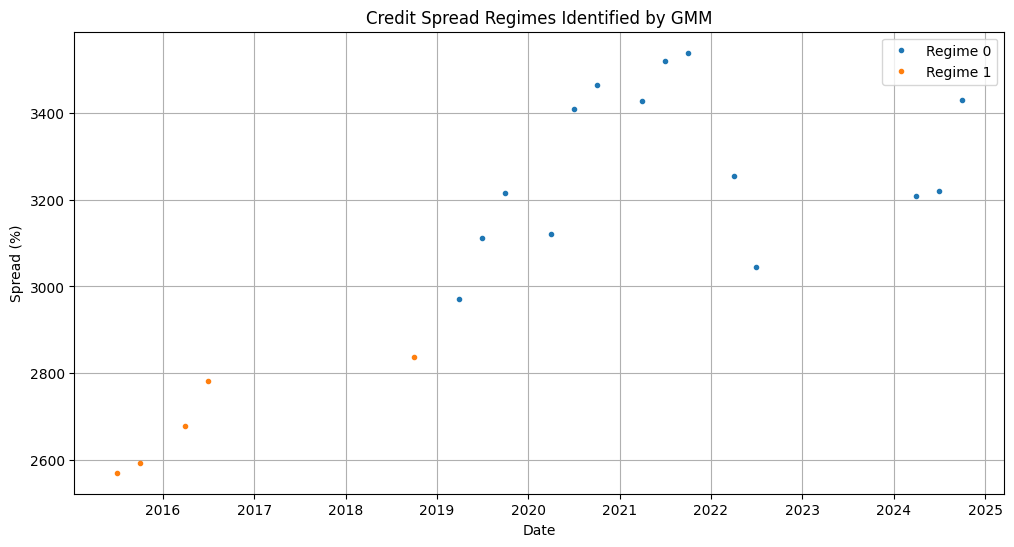

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     54.56
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.19e-08
Time:                        19:41:57   Log-Likelihood:                -109.00
No. Observations:                  19   AIC:                             228.0
Df Residuals:                      14   BIC:                             232.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7673.2079    857.101      8.953   

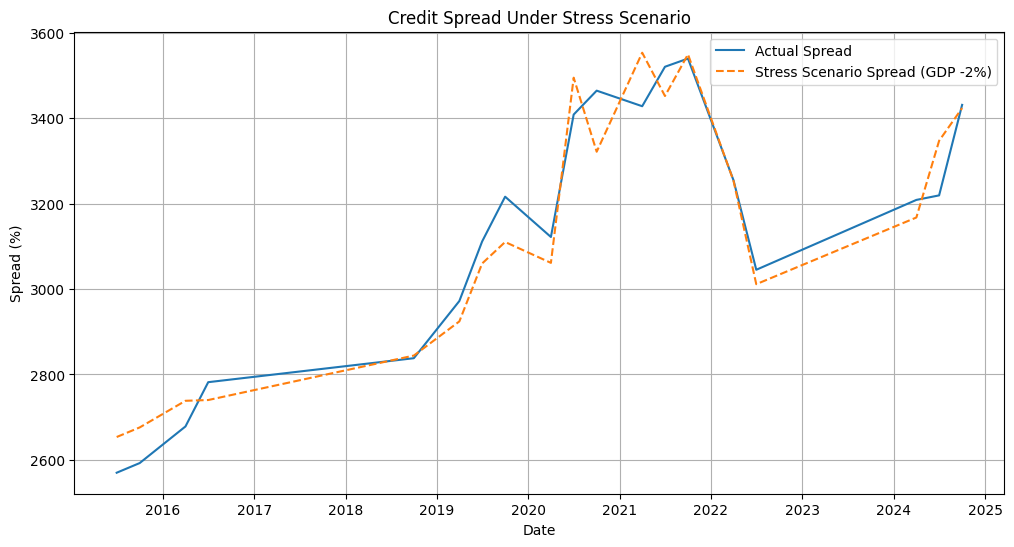

In [6]:
# Dynamic Term Structure Modeling of Corporate Bond Credit Spreads with Regime Switching and Macroeconomic Shocks
# ---------------------------------------------------------------

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from sklearn.mixture import GaussianMixture  # Alternative to HMM for regime classification

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# 2. Load Data
# Load files from current directory instead of /mnt/data

bond_yield = pd.read_csv('BAMLCC0A0CMTRIV.csv', parse_dates=['observation_date'])
treasury_yield = pd.read_csv('GS10.csv', parse_dates=['observation_date'])
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['observation_date'])
gdp = pd.read_csv('GDP.csv', parse_dates=['observation_date'])
unemployment = pd.read_csv('UNRATE.csv', parse_dates=['observation_date'])
fedfunds = pd.read_csv('FEDFUNDS.csv', parse_dates=['observation_date'])

# 3. Preprocessing
# Merge all datasets on DATE
merged = bond_yield.merge(treasury_yield, on='observation_date', how='inner')
merged = merged.merge(cpi, on='observation_date', how='left')
merged = merged.merge(gdp, on='observation_date', how='left')
merged = merged.merge(unemployment, on='observation_date', how='left')
merged = merged.merge(fedfunds, on='observation_date', how='left')

# Drop rows with missing data
merged.dropna(inplace=True)

# Rename columns for simplicity
merged.columns = ['Date', 'Corp_Yield', 'Treasury_Yield', 'CPI', 'GDP', 'Unemployment', 'FedFunds']

# Calculate Credit Spread
merged['Spread'] = merged['Corp_Yield'] - merged['Treasury_Yield']

# 4. Exploratory Data Analysis
plt.figure(figsize=(12,6))
plt.plot(merged['Date'], merged['Spread'])
plt.title('Corporate Bond Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.grid(True)
plt.savefig('plots/spread_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Gaussian Mixture Model (GMM) for Regime Detection
spread_values = merged['Spread'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(spread_values)
hidden_states = gmm.predict(spread_values)
merged['Regime'] = hidden_states

# Determine which regime is "Crisis" (higher average spread)
regime_means = merged.groupby('Regime')['Spread'].mean()
crisis_regime = regime_means.idxmax()
calm_regime = regime_means.idxmin()

print("Crisis Regime (Higher Spread):", crisis_regime)
print("Calm Regime (Lower Spread):", calm_regime)

# Plot regimes
plt.figure(figsize=(12,6))
for i in range(2):
    state = (merged['Regime'] == i)
    plt.plot(merged['Date'][state], merged['Spread'][state], '.', label=f'Regime {i}')
plt.legend()
plt.title('Credit Spread Regimes Identified by GMM')
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.grid(True)
plt.savefig('plots/regime_classification.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Overall Regression Analysis: Spread vs Macro Factors
X = merged[['CPI', 'GDP', 'Unemployment', 'FedFunds']]
X = sm.add_constant(X)
y = merged['Spread']
model = sm.OLS(y, X).fit()
print(model.summary())

# 7. Regime-Specific Regression Analyses
# Crisis Regime
crisis_data = merged[merged['Regime'] == crisis_regime]
X_crisis = crisis_data[['CPI', 'GDP', 'Unemployment', 'FedFunds']]
X_crisis = sm.add_constant(X_crisis)
y_crisis = crisis_data['Spread']
model_crisis = sm.OLS(y_crisis, X_crisis).fit()
print("\nRegression During Crisis Regime:")
print(model_crisis.summary())

# Calm Regime
calm_data = merged[merged['Regime'] == calm_regime]
X_calm = calm_data[['CPI', 'GDP', 'Unemployment', 'FedFunds']]
X_calm = sm.add_constant(X_calm)
y_calm = calm_data['Spread']
model_calm = sm.OLS(y_calm, X_calm).fit()
print("\nRegression During Calm Regime:")
print(model_calm.summary())

# 8. Stress Scenario Simulation
# Suppose a hypothetical 2% sudden drop in GDP
stress_macro = merged[['CPI', 'GDP', 'Unemployment', 'FedFunds']].copy()
stress_macro['GDP'] = stress_macro['GDP'] - 2.0
X_stress = sm.add_constant(stress_macro)
stress_spread = model.predict(X_stress)

plt.figure(figsize=(12,6))
plt.plot(merged['Date'], merged['Spread'], label='Actual Spread')
plt.plot(merged['Date'], stress_spread, label='Stress Scenario Spread (GDP -2%)', linestyle='--')
plt.title('Credit Spread Under Stress Scenario')
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.legend()
plt.grid(True)
plt.savefig('plots/stress_scenario_spread.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Conclusion
# - Two distinct spread regimes were identified: Calm and Crisis.
# - Macro factors have different impacts during each regime.
# - A simulated GDP shock significantly widens credit spreads.

# 10. Save Processed Data
merged.to_csv('credit_spread_regimes_final.csv', index=False)

# ---------------------------------------------------------------
# END OF PROJECT

# Future Recommendations:
# - Introduce Markov-Switching Regression models (dynamic coefficients)
# - Include corporate bond ratings (A, BBB) separately
# - Analyze volatility clustering (GARCH modeling)
# - Apply same analysis on global credit markets (Euro, Emerging Markets)
